## SETUP

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

df_2012 = pd.read_csv('../raw-data/2012-wages.csv', encoding='latin1')
df_2018 = pd.read_csv('../raw-data/2018-wages.csv', encoding='latin1')
df_2024 = pd.read_csv('../raw-data/2024-wages.csv', encoding='latin1')
df_skill = pd.read_csv('../raw-data/skill-gap.csv', encoding='latin1')
df_gender = pd.read_csv("../raw-data/gender.csv",encoding="latin1",on_bad_lines="skip",engine="python", )



# Cleaning
This section documents the steps taken to prepare the raw datasets for analysis.

## Wage Data
    Standardized column names across years

    Normalized NOC identifiers

    Standardized province and region labels

    Removed rows with missing wage values

    Combined all years into a single long-format dataset
## Gender Data
    Removed metadata and unused columns

    Standardized gender labels

    Restricted analysis to Canada

    Converted values to numeric format
## Skills Data
    Removed metadata columns

    Renamed variables for consistency

    Filtered to Canada-only observations

    Dropped missing values
    

In [87]:

# add year identifiers
df_2012["year"] = 2012
df_2018["year"] = 2018
df_2024["year"] = 2024


# rename columns to a consistent schema

# 2012
df_2012 = df_2012.rename(columns={
    "ï»¿NOC_CNP_2006": "noc",
    "NOC_Title": "noc_title",
    "PROV": "province",
    "ER_Code_Code_RE": "er_code",
    "ER_Name_Nom_RE": "er_name",
    "Low_Wage_Salaire_Minium": "low_wage",
    "Median_Wage_Salaire_Median": "median_wage",
    "High_Wage_Salaire_Maximal": "high_wage",
    "Annual_Wage_Flag_Salaire_annuel": "annual_flag",
    "Reference_Period": "reference_period",
})

keep_cols = [
    "noc", "noc_title", "province",
    "er_code", "er_name",
    "low_wage", "median_wage", "high_wage",
    "annual_flag", "reference_period",
    "year",
]

df_2012 = df_2012[keep_cols]


# 2018
df_2018 = df_2018.rename(columns={
    "NOC_CNP": "noc",
    "NOC Title": "noc_title",
    "Prov": "province",
    "ER Code_Code RE": "er_code",
    "ER Name_Nom RE": "er_name",
    "Low Wage_Salaire Minium": "low_wage",
    "Median wage_Salaire Median": "median_wage",
    "High Wage_Salaire maximal": "high_wage",
    "Annual Wage Flag_Salaire annuel": "annual_flag",
    "Reference Period_Periode de reference": "reference_period",
})

df_2018 = df_2018[keep_cols]


# 2024
df_2024 = df_2024.rename(columns={
    "ï»¿NOC_CNP": "noc",
    "NOC_Title_eng": "noc_title",
    "prov": "province",
    "ER_Code_Code_RE": "er_code",
    "ER_Name": "er_name",
    "Low_Wage_Salaire_Minium": "low_wage",
    "Median_Wage_Salaire_Median": "median_wage",
    "High_Wage_Salaire_Maximal": "high_wage",
    "Average_Wage_Salaire_Moyen": "average_wage",
    "Quartile1_Wage_Salaire_Quartile1": "q1_wage",
    "Quartile3_Wage_Salaire_Quartile3": "q3_wage",
    "Non_WageBen_pct": "non_wage_benefits_pct",
    "Annual_Wage_Flag_Salaire_annuel": "annual_flag",
    "Reference_Period": "reference_period",
})

df_2024 = df_2024[
    keep_cols
    + ["average_wage", "q1_wage", "q3_wage", "non_wage_benefits_pct"]
]


# standardize NOC identifiers
for df in [df_2012, df_2018, df_2024]:
    df["noc"] = (
        df["noc"]
        .astype(str)
        .str.replace("NOC_", "", regex=False)
        .str.lstrip("0")
    )


# combine all years into one dataset
wages_long = pd.concat([df_2012, df_2018, df_2024], ignore_index=True)


# standardize province labels
province_map = {
    "Newfoundland and Labrador": "NL",
    "Prince Edward Island": "PE",
    "Nova Scotia": "NS",
    "New Brunswick": "NB",
    "Quebec": "QC",
    "Ontario": "ON",
    "Manitoba": "MB",
    "Saskatchewan": "SK",
    "Alberta": "AB",
    "British Columbia": "BC",
    "Yukon Territory": "YT",
    "Northwest Territories": "NT",
    "Nunavut": "NU",
    "National": "NAT",
    "Canada": "NAT",
}

wages_long["province"] = wages_long["province"].replace(province_map)

wages_long["province"] = wages_long["province"].replace({
    "PEI": "PE",
    "NW": "NWT",
    "NT": "NWT",
    "YK": "YT",
})


# drop rows missing median wage (used in analysis)
wages_long = wages_long.dropna(subset=["median_wage"])

In [88]:
# fix broken column name
df_gender.columns = df_gender.columns.str.replace('ï»¿"', '').str.replace('"', '')

# drop unused / duplicate columns
df_gender = df_gender.drop(columns=[
    "DGUID", "VECTOR", "COORDINATE",
    "STATUS", "SYMBOL", "TERMINATED", "DECIMALS",
    "gender"
], errors="ignore")

# fix numeric values
df_gender["VALUE"] = pd.to_numeric(df_gender["VALUE"], errors="coerce")


In [89]:
df_skill = df_skill.drop(columns=[
    "DGUID", "vector", "coordinate",
    "status", "symbol", "terminated", "decimals",
    "unit_of_measurement_id", "scalar_factor", "scalar_id"
], errors="ignore")


# Data Transformation

## Wage Data 
    Separated hourly and annual wages

    Created AI exposure proxy using NOC major groups

    Constructed wage inequality measure (wage gap ratio)

    Applied log transformation to address skewness and outliers
## Skills Data 
    Filtered to skill-related actions (training, upskilling, hiring)

    Aggregated employer responses to infer skill gap patterns


In [90]:
# split hourly vs annual wages
wages_hourly = wages_long[wages_long["annual_flag"] == 0].copy()
wages_annual = wages_long[wages_long["annual_flag"] == 1].copy()


# create AI exposure proxy using NOC major groups
ai_exposed_nocs = ["0", "1", "2", "3"]

wages_hourly["ai_exposed"] = wages_hourly["noc"].str[0].isin(ai_exposed_nocs)


# create wage inequality measure
wages_long["wage_gap_ratio"] = (
    wages_long["high_wage"] - wages_long["low_wage"]
) / wages_long["median_wage"]


In [91]:
# 1. Rename columns to a consistent schema
df_gender = df_gender.rename(columns={
    "REF_DATE": "year",
    "National Occupational Classification (NOC)": "noc",
    "Type of work": "work_type",
    "Age group": "age_group",
    "VALUE": "value"
})

# 2. Keep only columns that actually exist and are needed
df_gender = df_gender[
    ["year", "GEO", "Gender", "age_group", "noc", "work_type", "value"]
]

# 3. Standardize gender labels
df_gender["Gender"] = df_gender["Gender"].replace({
    "Men+": "Male",
    "Women+": "Female",
    "Total - Gender": "Total"
})

# 4. Drop rows with missing values
df_gender = df_gender.dropna(subset=["value"])

# 5. Restrict to Canada only
df_gender = df_gender[df_gender["GEO"] == "Canada"]

# 6. Ensure correct data types
df_gender["year"] = df_gender["year"].astype(int)
df_gender["value"] = df_gender["value"].astype(float)


In [92]:
# rename only columns that matter for the RQs
df_skill = df_skill.rename(columns={
    'ï»¿"REF_DATE"': "year",
    "Business characteristics": "business_type",
    "Actions planned by businesses or organizations to address skills gaps or employee skill deficiencies over the next 12 months": "skill_action",
    "UOM": "measure",
    "VALUE": "value"
})

# keep only RQ-relevant columns
df_skill = df_skill[
    ["year", "GEO", "business_type", "skill_action", "measure", "value"]
]

# restrict to Canada
df_skill = df_skill[df_skill["GEO"] == "Canada"]

# drop unusable rows
df_skill = df_skill.dropna(subset=["value"])
df_skill


,year,GEO,business_type,skill_action,measure,value
0,2023,Canada,North American Industry Classification System ...,Provide internal training or on-the-job (in-ho...,Percent,62.3
1,2023,Canada,North American Industry Classification System ...,Provide external training,Percent,22.9
2,2023,Canada,North American Industry Classification System ...,Implement a mentoring or coaching scheme,Percent,24.3
3,2023,Canada,North American Industry Classification System ...,Increase performance monitoring,Percent,26.5
4,2023,Canada,North American Industry Classification System ...,Provide feedback to staff,Percent,40.2
...,...,...,...,...,...,...
933,2023,Canada,"Business or organization activity, none or other",Implement outsourcing or offshoring,Percent,1.3
934,2023,Canada,"Business or organization activity, none or other",Drop some activities,Percent,5.5
935,2023,Canada,"Business or organization activity, none or other",Actions planned by businesses or organizations...,Percent,0.7
936,2023,Canada,"Business or organization activity, none or other",Actions planned by businesses or organizations...,Percent,6.3


# Research Question 1 – Industry & Region
How have wages changed across industries and regions from 2012 to 2024, and what patterns may be linked to AI adoption?

## EDA 
    Compared hourly and annual wage trends by province

    Examined wage distributions across occupations

    Analyzed wage differences between AI-exposed and non-exposed occupations
## Findings
    Wages increased consistently across provinces and occupations

    Territories and specialized regions exhibit higher wages

    AI-exposed occupations consistently earn higher wages

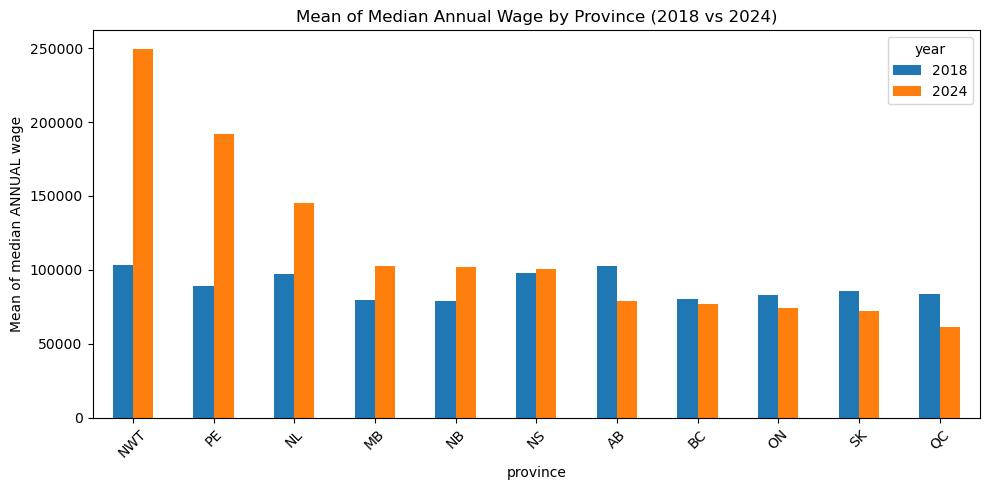

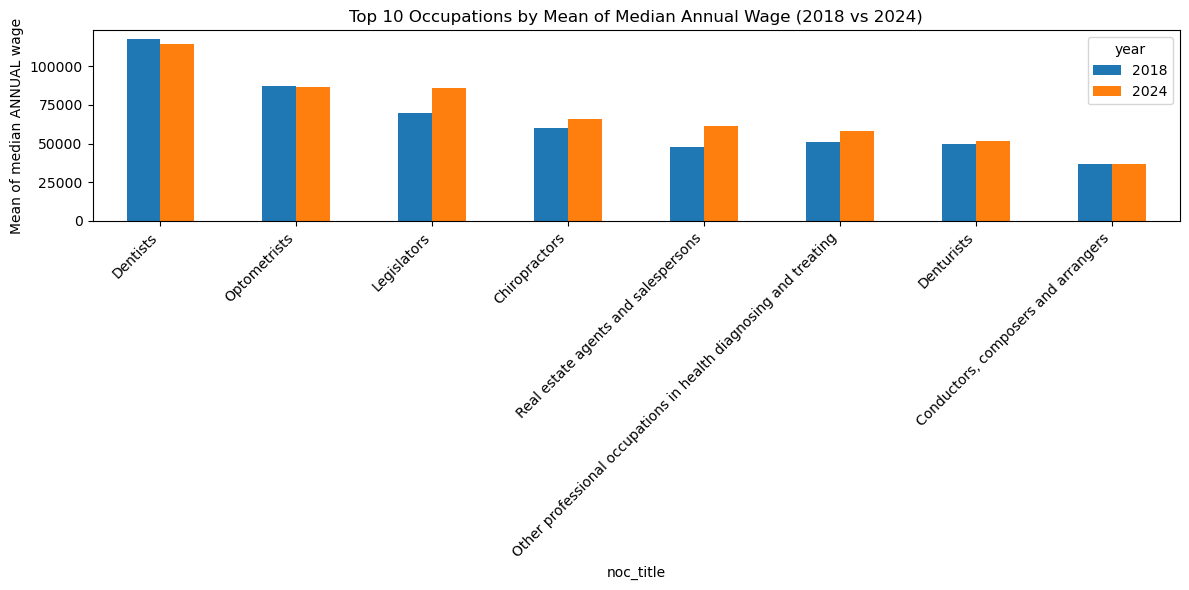

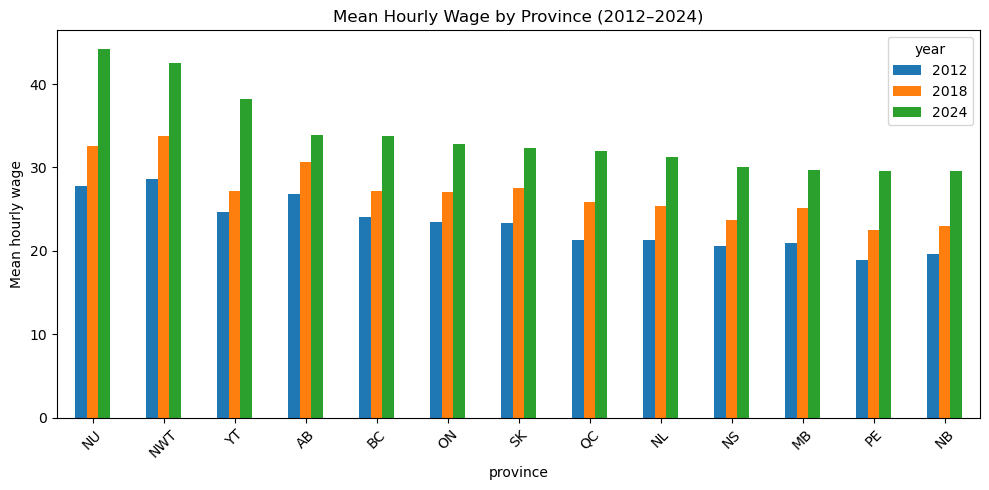

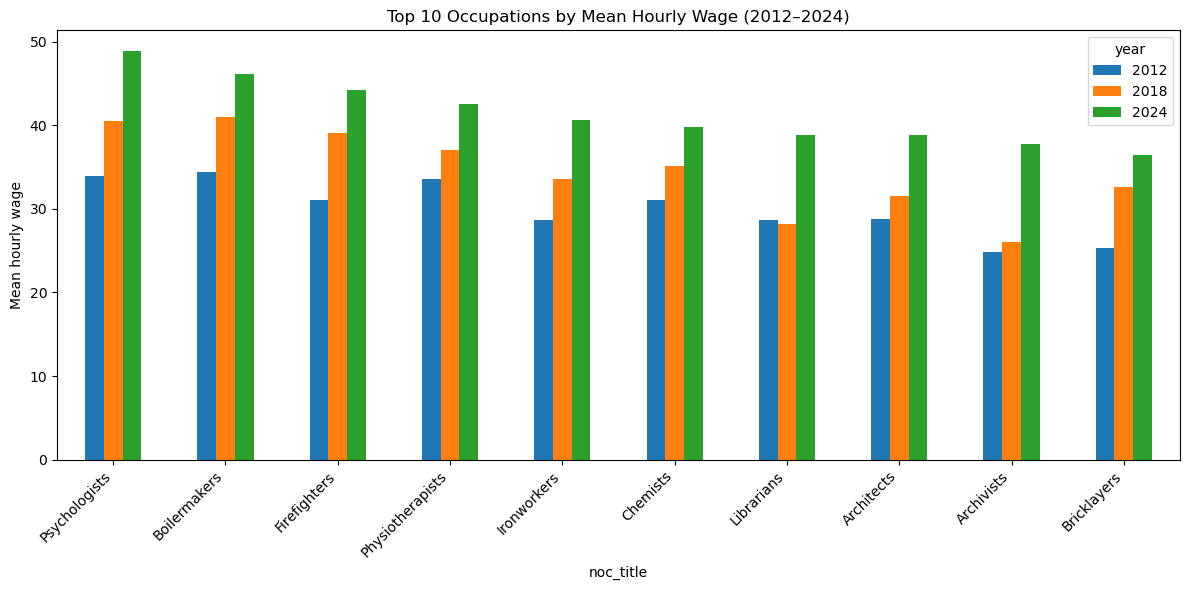

In [93]:
 # This section uses BOTH annual and hourly wage records.
# It assumes wages_long exists from Cleaning.

assert "wages_long" in globals(), "Run Cleaning first: wages_long is missing."

# ensure numeric wages (safe even if already numeric)
for col in ["low_wage", "median_wage", "high_wage"]:
    if col in wages_long.columns:
        wages_long[col] = pd.to_numeric(wages_long[col], errors="coerce")

# define hourly vs annual subsets (make copies to avoid chained-assignment issues)
wages_hourly = wages_long[wages_long["annual_flag"] == 0].copy()
wages_annual = wages_long[wages_long["annual_flag"] == 1].copy()


# -----------------------------
# A) ANNUAL EDA (Region + Industry)
# -----------------------------

# ANNUAL: Region (Province) — compare 2018 vs 2024
wages_annual_eda = wages_annual[wages_annual["year"].isin([2018, 2024])].copy()

prov_annual = (
    wages_annual_eda
    .groupby(["year", "province"])["median_wage"]
    .mean()
    .reset_index()
)

prov_annual_pivot = (
    prov_annual
    .pivot(index="province", columns="year", values="median_wage")
    .dropna()
    .sort_values(by=2024, ascending=False)
)

prov_annual_pivot.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Mean of median ANNUAL wage")
plt.title("Mean of Median Annual Wage by Province (2018 vs 2024)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ANNUAL: Industry (Occupation) — compare 2018 vs 2024
# note:  dropna() keeps only occupations present in BOTH 2018 and 2024 for a fair comparison.
occ_annual = (
    wages_annual_eda
    .groupby(["year", "noc_title"])["median_wage"]
    .mean()
    .reset_index()
)

occ_annual_pivot = (
    occ_annual
    .pivot(index="noc_title", columns="year", values="median_wage")
    .dropna()
)

top10_annual_titles = occ_annual_pivot.sort_values(by=2024, ascending=False).head(10)
top10_annual_titles.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Mean of median ANNUAL wage")
plt.title("Top 10 Occupations by Mean of Median Annual Wage (2018 vs 2024)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# -----------------------------
# B) HOURLY EDA (Region + Industry)
# -----------------------------

# HOURLY: Region (Province) — trend across 2012, 2018, 2024
prov_hourly = (
    wages_hourly
    .groupby(["year", "province"])["median_wage"]
    .mean()
    .reset_index()
)

prov_hourly_pivot = (
    prov_hourly
    .pivot(index="province", columns="year", values="median_wage")
    .dropna()
    .sort_values(by=2024, ascending=False)
)

prov_hourly_pivot.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Mean hourly wage")
plt.title("Mean Hourly Wage by Province (2012–2024)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# HOURLY: Industry (Occupation) — trend across 2012, 2018, 2024
# note: this keeps occupations that appear in all selected years (comparability > coverage).
occ_hourly = (
    wages_hourly[wages_hourly["year"].isin([2012, 2018, 2024])]
    .groupby(["year", "noc_title"])["median_wage"]
    .mean()
    .reset_index()
)

occ_hourly_pivot = (
    occ_hourly
    .pivot(index="noc_title", columns="year", values="median_wage")
    .dropna()
)

top10_hourly_titles = occ_hourly_pivot.sort_values(by=2024, ascending=False).head(10)
top10_hourly_titles.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Mean hourly wage")
plt.title("Top 10 Occupations by Mean Hourly Wage (2012–2024)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

   year  ai_exposed  median_wage
0  2012       False    20.907171
1  2012        True    25.877439
2  2018       False    24.744822
3  2018        True    30.123910
4  2024       False    30.032153
5  2024        True    36.047595


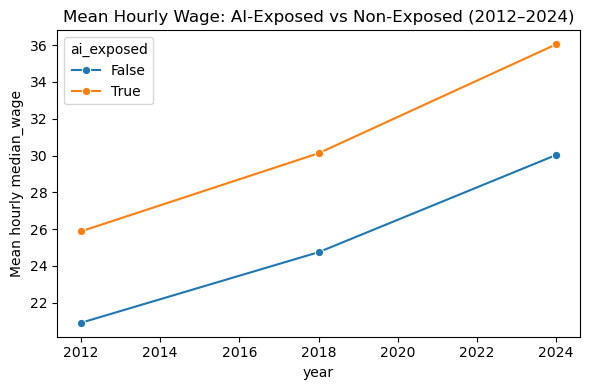

year        abs_change_2012_2024  pct_change_2012_2024
ai_exposed                                            
False                   9.124982             43.645227
True                   10.170156             39.301246


In [94]:
wages_hourly = wages_long[wages_long["annual_flag"] == 0].copy()

wages_hourly["median_wage"] = pd.to_numeric(wages_hourly["median_wage"], errors="coerce")
wages_hourly = wages_hourly.dropna(subset=["median_wage"])

# AI-exposed NOC major groups (first digit):
# 0 = Management
# 1 = Business, finance and administration
# 2 = Natural and applied sciences and related occupations
# 3 = Health occupations
wages_hourly["ai_exposed"] = wages_hourly["noc"].astype(str).str[0].isin(["0", "1", "2", "3"])

ai_year_summary = (
    wages_hourly[wages_hourly["year"].isin([2012, 2018, 2024])]
    .groupby(["year", "ai_exposed"])["median_wage"]
    .mean()
    .reset_index()
)

print(ai_year_summary)

plt.figure(figsize=(6, 4))
sns.lineplot(data=ai_year_summary, x="year", y="median_wage", hue="ai_exposed", marker="o")
plt.title("Mean Hourly Wage: AI-Exposed vs Non-Exposed (2012–2024)")
plt.ylabel("Mean hourly median_wage")
plt.tight_layout()
plt.show()

wide = ai_year_summary.pivot(index="ai_exposed", columns="year", values="median_wage")
wide["abs_change_2012_2024"] = wide[2024] - wide[2012]
wide["pct_change_2012_2024"] = (wide["abs_change_2012_2024"] / wide[2012]) * 100

print(wide[["abs_change_2012_2024", "pct_change_2012_2024"]])


# Research Question 2 – Demographics
How do demographic factors influence access to AI-related opportunities?

## EDA 
    Inspected wage dataset for demographic variables

    Used distribution plots to examine wage structure

    Analyzed occupation and geography as indirect demographic proxies

## Findigs
    Direct demographic wage analysis is not possible with wage data alone

    Wage distributions are highly skewed

    Occupational and regional sorting likely reflects structural demographic access

In [95]:
# quick look at columns
sorted (wages_long. columns)

['annual_flag',
 'average_wage',
 'er_code',
 'er_name',
 'high_wage',
 'low_wage',
 'median_wage',
 'noc',
 'noc_title',
 'non_wage_benefits_pct',
 'province',
 'q1_wage',
 'q3_wage',
 'reference_period',
 'wage_gap_ratio',
 'year']

In [96]:
import re

demographic_keywords = [
    "gender", "sex", "male", "female",
    "race", "ethnic", "ethnicity",
    "immigrant", "minority",
    "income", "household",
    "education", "age"
]

[col for col in wages_long.columns
 if any(re.search(rf"\b{key}\b", col.lower()) for key in demographic_keywords)]

# Perfect!!!! we got an empty list since none of the variables correspod to demographic attributes. 

[]

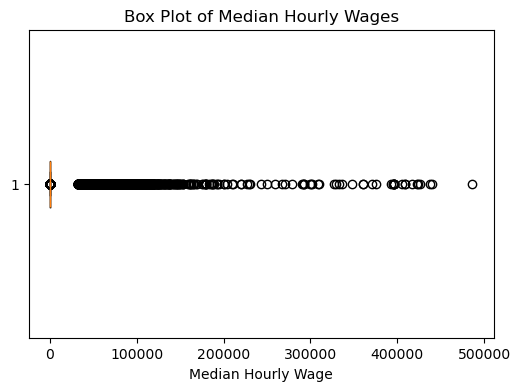

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(wages_long["median_wage"].dropna(), vert=False)
plt.xlabel("Median Hourly Wage")
plt.title("Box Plot of Median Hourly Wages")
plt.show()

# looks weird so we are going to log transform it and try a stripplot instead

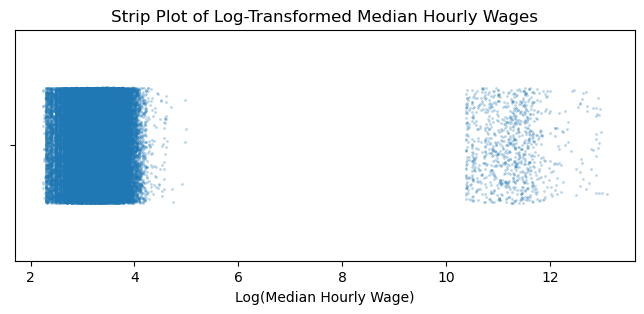

In [98]:
import numpy as np

wages_long["log_median_wage"] = np.log(wages_long["median_wage"])

plt.figure(figsize=(8, 3))
sns.stripplot(
    x=wages_long["log_median_wage"],
    jitter=0.25,
    size=2,
    alpha=0.3
)

plt.xlabel("Log(Median Hourly Wage)")
plt.title("Strip Plot of Log-Transformed Median Hourly Wages")
plt.show()

# this actually tells us something!!!!

Using a log-transformation we were able to fix the issue of outliers and create the stripplot above. 

The strip plot of log-transformed median wages reveals two distinct clusters. The primary cluster corresponds to plausible hourly wages across most occupations, while a smaller secondary cluster reflects extremely high reported values likely arising from reporting inconsistencies or non-hourly wage scales. For interpretability, subsequent visual analysis restricts attention to plausible hourly wage ranges.

In [99]:
# confirm what is available instead!!!

wages_long[[
    "noc",
    "noc_title",
    "province",
    "er_name",
    "year",
    "median_wage",
    "average_wage"
]].info()


<class 'pandas.core.frame.DataFrame'>
Index: 57353 entries, 0 to 132089
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   noc           57353 non-null  object 
 1   noc_title     57353 non-null  object 
 2   province      56855 non-null  object 
 3   er_name       57353 non-null  object 
 4   year          57353 non-null  int64  
 5   median_wage   57353 non-null  float64
 6   average_wage  19022 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.5+ MB


Since direct demographics are missing, we analyze occupation and geography, which often correlate with demographic access based on common knowledge. 

Text(0.5, 1.0, 'Wage differeces across occupations')

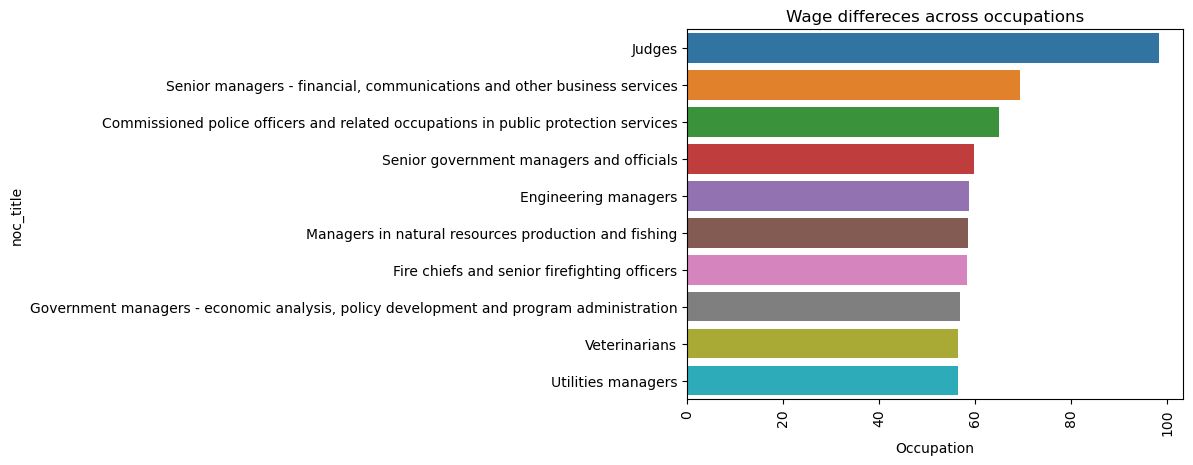

In [100]:

# wages difference by occupation
(
    wages_long
    .groupby("noc_title", as_index=False)
    .agg(
        mean_median_wage=("median_wage", "mean"),
        count=("median_wage", "count")
    )
    .sort_values("mean_median_wage", ascending=False)
    .head(10)
)

wages_hourly_only = wages_long[wages_long["median_wage"] < 200]

top_occ_hourly = (
    wages_hourly_only
    .groupby("noc_title", as_index=False)
    .agg(mean_median_wage=("median_wage", "mean"))
    .sort_values("mean_median_wage", ascending=False)
    .head(10)
)

sns.barplot(data=top_occ_hourly, x='mean_median_wage', y='noc_title', hue='noc_title', orient='h', legend=False)
plt.xticks(rotation=90)
plt.xlabel("Occupation")
plt.title('Wage differeces across occupations')

It makes a lot of sense even based on common knowledge was judges to not be involved with AI so our logic checks out too!

Text(0.5, 1.0, 'Wage differeces across occupations')

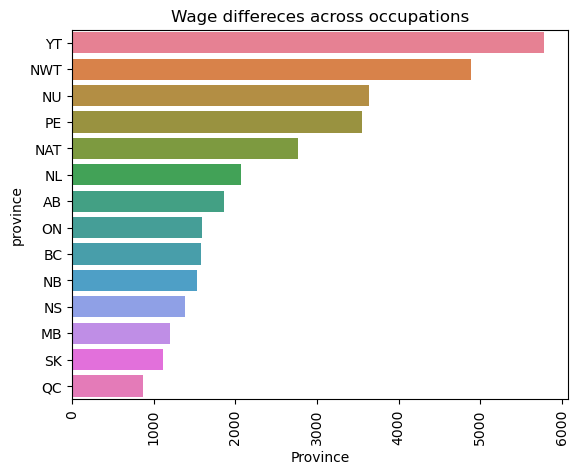

In [101]:
# wages differences by provinces

(
    wages_long
    .groupby("province", as_index=False)
    .agg(mean_median_wage=("median_wage", "mean"))
    .sort_values("mean_median_wage", ascending=False)
)


prov_wages = (
    wages_long
    .groupby("province", as_index=False)
    .agg(mean_median_wage=("median_wage", "mean"))
    .sort_values("mean_median_wage", ascending=False)
)

sns.barplot(data=prov_wages, x='mean_median_wage', y='province', hue='province', orient='h', legend=False)
plt.xticks(rotation=90)
plt.xlabel("Province")
plt.title('Wage differeces across occupations')

The wage dataset does not contain direct demographic information such as gender, race, ethnicity, age, education, or household income. This was confirmed by inspecting the dataset’s columns and searching explicitly for common demographic indicators.

As a result, direct demographic wage gap analysis is not possible using this dataset alone.

#### Limitations
Because wages are reported at the occupation–region–year level rather than the individual level, the data:
Cannot measure gender or racial wage gaps
Cannot identify within-occupation demographic inequality
Aggregates workers into broad occupational categories
Any demographic conclusions drawn directly from this dataset would therefore be speculative and methodologically invalid.

#### Indirect demographic implications
Although explicit demographic variables are absent, access to occupations is not demographically neutral. Differences observed across occupations and regions may indirectly reflect demographic sorting due to:
- Educational requirements
- Skill barriers
- Credential access
- Historical and structural inequalities

For example, occupations with higher AI exposure and higher wages often require advanced education, which may disproportionately exclude certain demographic groups.

#### Conclusion
This dataset is suitable for analyzing occupational and regional wage patterns, but not for direct demographic wage inequality. Any discussion of demographics must therefore be framed as indirect and structural, not empirical measurement.

# Research Question 3 – Diversity, Equity & Skill Gaps
What trends are observed in workforce diversity, wage equity, and skill gaps?

## EDA 
    Compared workforce representation by gender

    Examined wage dispersion across occupations

    Analyzed employer responses to skill gaps using skills dataset
## Findings
    Workforce participation differs by gender

    Wage benefits are unevenly distributed

    Employers rely primarily on internal training rather than large-scale reskilling
    

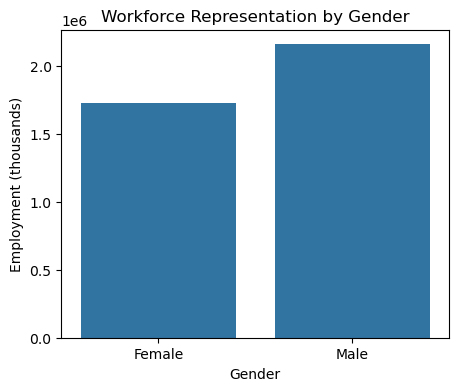

In [102]:
gender_totals = (
    df_gender[df_gender["Gender"] != "Total"]
    .groupby("Gender")["value"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(5,4))
sns.barplot(
    data=gender_totals,
    x="Gender",
    y="value"
)
plt.ylabel("Employment (thousands)")
plt.title("Workforce Representation by Gender")
plt.show()


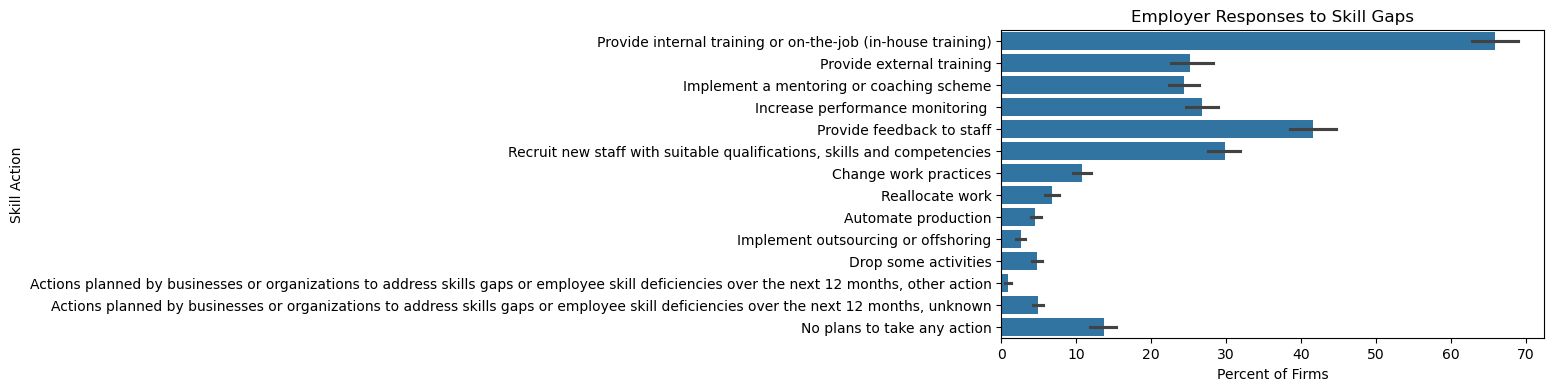

In [103]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=df_skill,
    y="skill_action",
    x="value"
)
plt.xlabel("Percent of Firms")
plt.ylabel("Skill Action")
plt.title("Employer Responses to Skill Gaps")
plt.show()


# 6. Research Question 4 – Benefits & Barriers
Which groups are most likely to benefit from AI adoption, and which face barriers?

## EDA 
    Compared wage distributions by AI exposure

    Examined wage dispersion and inequality measures

    Estimated regression between median wage and wage spread

## Findings
    AI-exposed occupations have higher wages and larger dispersion

    Benefits are concentrated rather than evenly shared

    Lower-skill occupations face relative barriers to AI-driven gains


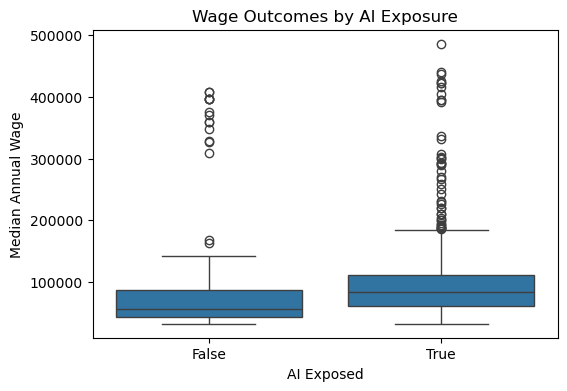

In [104]:
# example: AI-exposed based on first digit of NOC
ai_exposed_nocs = ["0", "1", "2", "3"]

wages_annual["ai_exposed"] = wages_annual["noc"].str[0].isin(ai_exposed_nocs)

plt.figure(figsize=(6,4))
sns.boxplot(
    data=wages_annual,
    x="ai_exposed",
    y="median_wage"
)
plt.xlabel("AI Exposed")
plt.ylabel("Median Annual Wage")
plt.title("Wage Outcomes by AI Exposure")
plt.show()


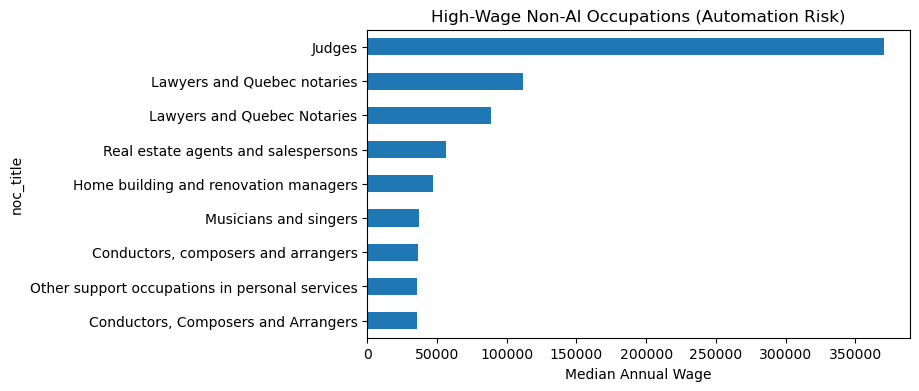

In [105]:
high_wage_non_ai = (
    wages_annual[~wages_annual["ai_exposed"]]
    .groupby("noc_title")["median_wage"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(7,4))
high_wage_non_ai.plot(kind="barh")
plt.xlabel("Median Annual Wage")
plt.title("High-Wage Non-AI Occupations (Automation Risk)")
plt.gca().invert_yaxis()
plt.show()


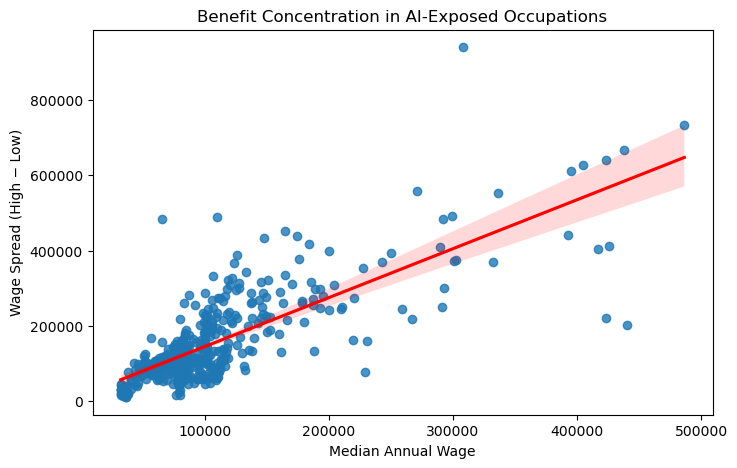

RQ4 — Benefit Concentration (AI Occupations)
Slope: 1.2982
Intercept: 15276.9892
R-squared: 0.5979
P-value: 1.0661e-86


In [106]:
# Prepare data once
rq4_df = (
    wages_annual[wages_annual["ai_exposed"]]
    .assign(wage_spread=lambda x: x["high_wage"] - x["low_wage"])
    .dropna(subset=["median_wage", "wage_spread"])
)

# Scatter + regression line
plt.figure(figsize=(8,5))
sns.regplot(
    data=rq4_df,
    x="median_wage",
    y="wage_spread",
    line_kws={"color": "red"}
)
plt.xlabel("Median Annual Wage")
plt.ylabel("Wage Spread (High − Low)")
plt.title("Benefit Concentration in AI-Exposed Occupations")
plt.show()

# Linear regression statistics (robust unpacking)
slope, intercept, r_value, p_value, std_err = linregress(
    rq4_df["median_wage"],
    rq4_df["wage_spread"]
)

print("RQ4 — Benefit Concentration (AI Occupations)")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")


# Main Results & Conclusions

## Summary of Key Findings
    Wage growth is widespread but uneven

    AI exposure correlates with higher wages and greater inequality

    Skill gaps and credential barriers shape access to benefits

    AI adoption appears to reinforce existing labour market stratification

## Limitations
    AI exposure measured using occupational proxy

    Aggregated data limits causal inference

    Lack of individual-level demographic data

## Conclusion
    AI adoption in Canada is associated with higher wages for skilled occupations but also increased inequality. Without targeted policy and training interventions, AI-driven growth may disproportionately benefit already advantaged groups.